# Fisherfaces Face Recognition


In [337]:
import glob
import os
import numpy as np
from collections import defaultdict
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from collections import Counter

## Read Images

Load the training images from training dataset.

In [338]:
path_to_images = "/dataset/train_images/*.*.jpg"  # path to the training images
path = os.getcwd()
images_path =  glob.glob(path + path_to_images)

IMG_CLASS = defaultdict(list)
LABELS = {}

for idx, image_name in enumerate(images_path):
    person_name = image_name.split("/")[-1].split("\\")[-1].split(".")[0]
    IMG_CLASS[person_name].append(idx)
    LABELS[idx] = person_name

raw_images = [mpimg.imread(file) for file in images_path]

## Crop Images
Resize images to make them N X N, where N is 130.

In [339]:
# crop the images into an N x N square
dimensions = (80, 210, 120, 250)
startx, endx, starty, endy = dimensions

# crop the images
images = [image[startx:endx, starty:endy] for image in raw_images]

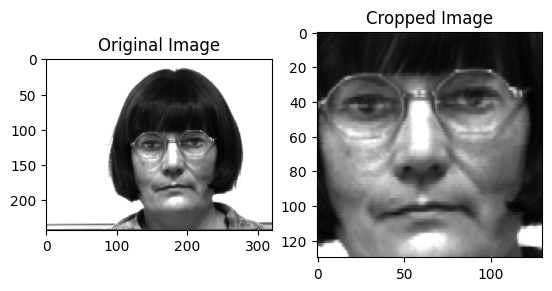

Original Dimension (130, 130)
Cropped Dimension (130, 130)


In [340]:
# cropped image
# make room for all the images
fig, ax = plt.subplots(1, 2)

random_image = np.random.randint(0, len(raw_images))

# plot the original image
ax[0].imshow(raw_images[random_image], cmap="gray")
ax[0].set_title("Original Image")

# plot the cropped image
ax[1].imshow(images[random_image], cmap="gray")
ax[1].set_title("Cropped Image")

# display the plot
plt.show()

print("Original Dimension", images[0].shape)
print("Cropped Dimension", images[0].shape)

# from now on we'll work on the cropped images
images = np.array(images)

In [341]:

def show_images(images):
    fig, ax = plt.subplots(len(IMG_CLASS), 10, figsize=(20, 20))

    for row, person in enumerate(IMG_CLASS):
        row -= 1
        for idx in IMG_CLASS[person]:
            image = images[idx]

            idx %= 10
            ax[row][idx].imshow(image.reshape(130, 130), cmap="gray")
            ax[row][idx].set_title(person)
            ax[row][idx].axis("off")

    plt.show()

## Flatten the images

In [342]:

flattend_images = [np.array(image).flatten() for image in images]
flattend_images = np.array(flattend_images)

print("Dimension of the flattened image: ", flattend_images.shape)

Dimension of the flattened image:  (100, 16900)


## Compute the average face for all persons

In [343]:
# computing the average face for all images
avg_face = np.mean(flattend_images, axis=0)

# Compute average face for each person

In [344]:
class_mean = {}

# for each person calculate the mean face
for person in IMG_CLASS:
    person_images = []
    for idx in IMG_CLASS[person]:
        person_images.append(images[idx].flatten())

    class_mean[person] = np.mean(person_images, axis=0)

## Subtract the mean person face from each image

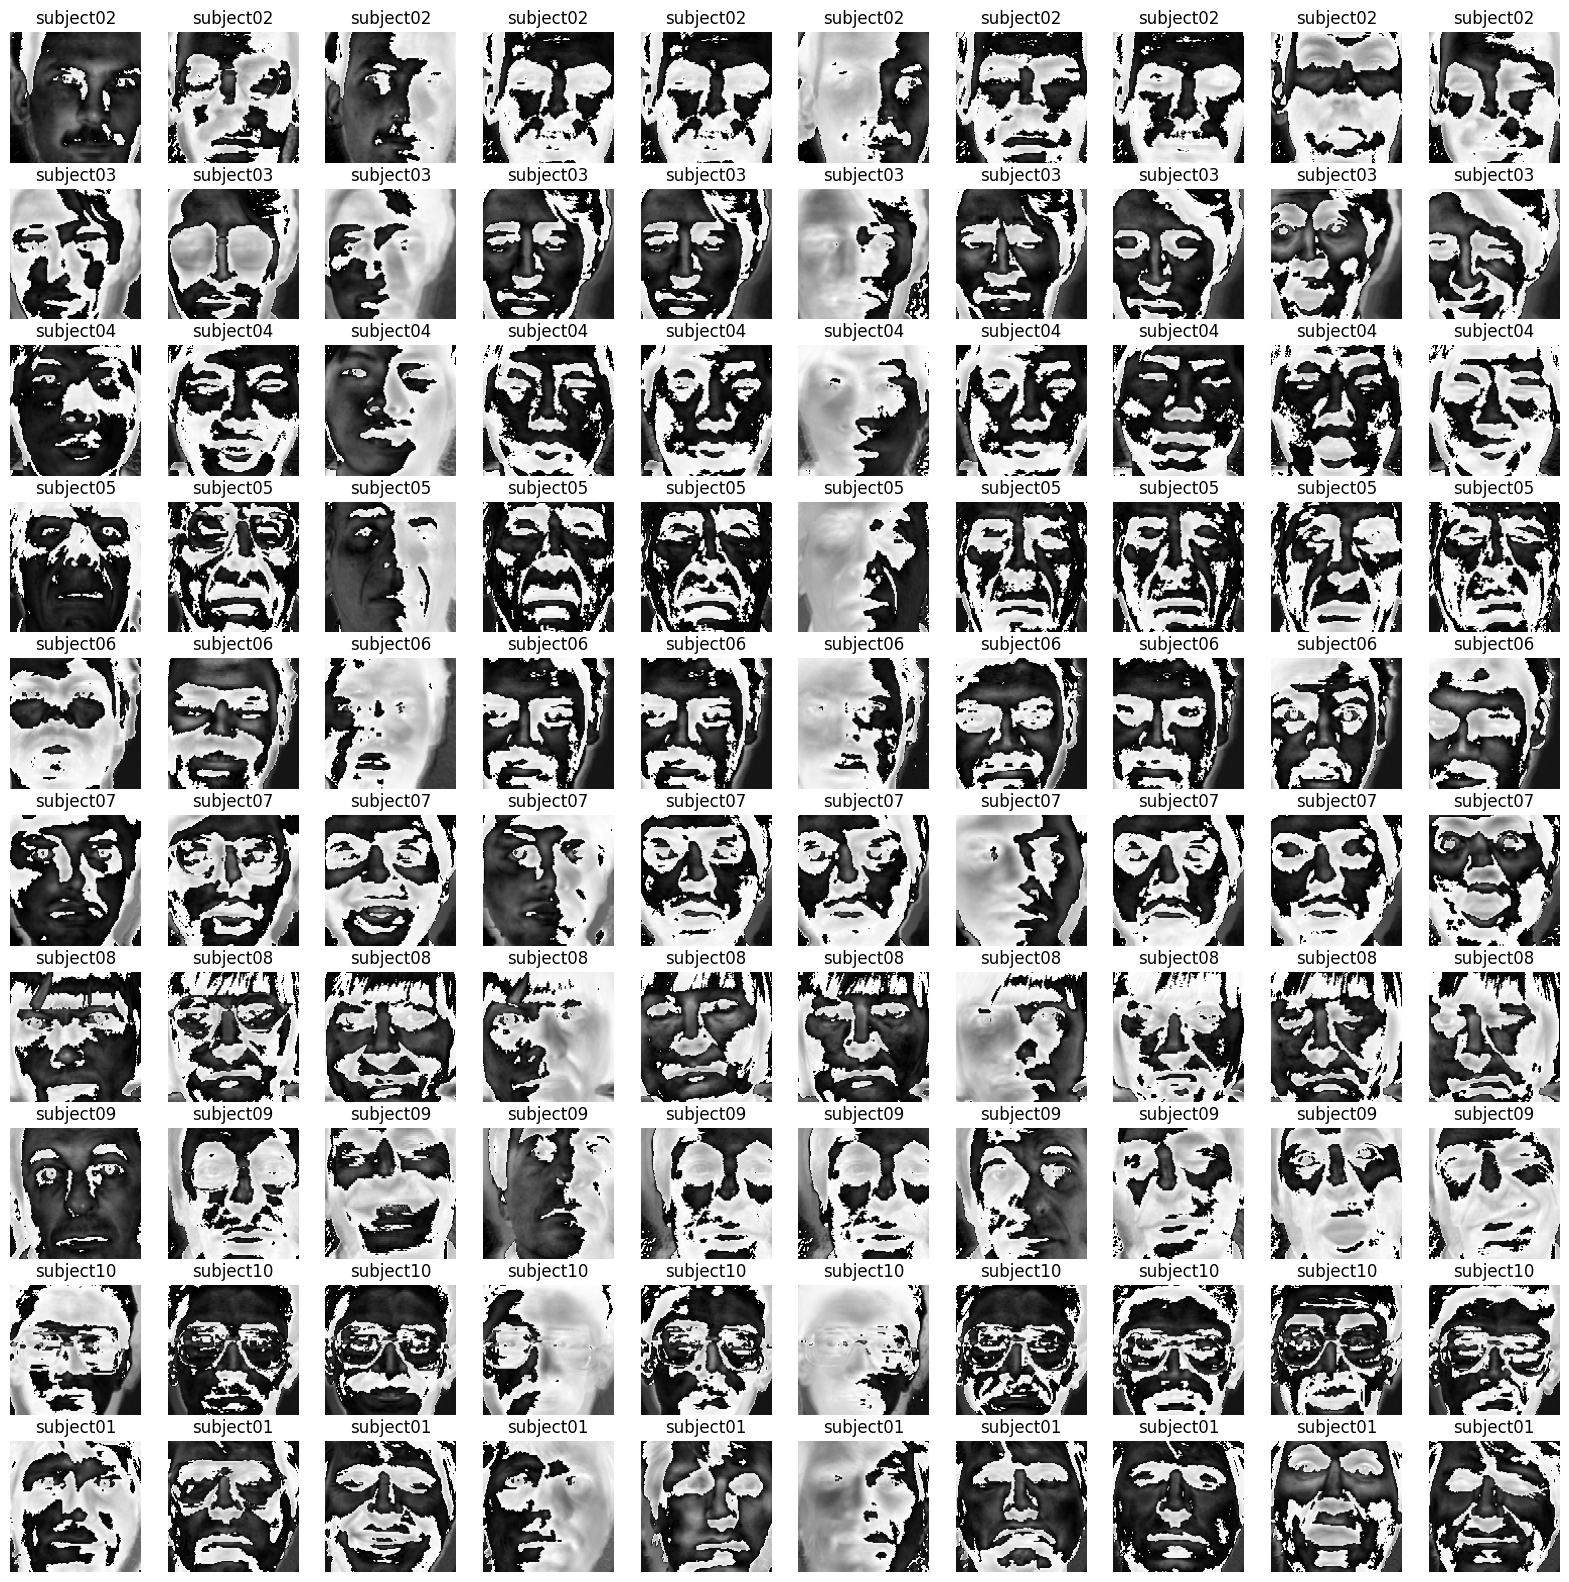

In [345]:

for person_name in IMG_CLASS:
    for img_idx in IMG_CLASS[person_name]:
        flattend_images[img_idx] = flattend_images[img_idx] - class_mean[person_name]

show_images(flattend_images)

## Calculate per person (per class) scatter matrices

In [346]:
def calc_scatter_mat(images, class_mean, avg_face):
    Sw = np.zeros((images.shape[1], images.shape[1]))
    Sb = np.zeros((images.shape[1], images.shape[1]))

    for person in IMG_CLASS:
        scatter_val = np.zeros((images.shape[1], images.shape[1]))

        for idx in IMG_CLASS[person]:
            image = images[idx]
            scatter_val += np.dot(image, image.T)
        
        Sw += scatter_val
        mean_scatter_val = class_mean[person] - avg_face
        Sb += np.dot(mean_scatter_val, mean_scatter_val.T) * len(IMG_CLASS[person])

    return Sw, Sb


Sw, Sb = calc_scatter_mat(images, class_mean, avg_face)
print("Sw shape: {}, Sb shape: {}".format(Sw.shape, Sb.shape))


Sw shape: (130, 130), Sb shape: (130, 130)


## Solving The Problem

In [347]:
# matrix for holding s_w^-1 * s_b
problem = np.linalg.inv(Sw.T).dot(Sb.T)

U, S, _ = np.linalg.svd(problem)

print(f'Shape of the decomposed vectors : {U.shape}')

# put the eigenvectors and eigenvalues in pair : (eigenvalue , eigenvector)
eigen_pairs = [(np.abs(S[i]), U[:, i]) for i in range(len(S))]

# sort the eigenpairs
eigen_pairs.sort(key=lambda element: element[0], reverse=True)

Shape of the decomposed vectors : (130, 130)


## K Significant Eigenfaces

In [348]:
# sum of the total eigen values
total = np.array([pair[0] for pair in eigen_pairs])
total = total.sum()


# select the importat eigenvector
selectedVectors = np.array([eigen_pairs[i][1] for i in range(len(eigen_pairs))])

print(f'Shape of selected K components : {selectedVectors.shape}')

Shape of selected K components : (130, 130)


## Project test images onto the LDA subspace

In [349]:
images_in_lda_space = np.dot(images, selectedVectors.T)

## Testing / Recognizing new Images
For fisherfaces, we use the nearest neighbor classifier with Euclidean distance metric to recognize new faces.

In [350]:
test_images = glob.glob(path + "/dataset/test_images/*.*.jpg")

actual_test_image_label = {}

for idx, image_name in enumerate(test_images):
    person_name = image_name.split("/")[-1].split("\\")[-1].split(".")[0]
    actual_test_image_label[idx] = person_name

test_images = [mpimg.imread(file) for file in test_images]
print("Number of test images: ", len(test_images))

# crop the images
test_images_cropped = [image[startx:endx, starty:endy] for image in test_images]


# flatten the images
test_images_flattened = [image.flatten() for image in test_images_cropped]

# vectorize
test_images_flattened = np.array(test_images_flattened)

flattened_avg_face  = avg_face.flatten()
# subtract the mean face
test_images_normalized = test_images_flattened - flattened_avg_face

# project the images into the new space
test_images_in_new_space = np.dot(test_images_normalized, selectedVectors.T.flatten())

Number of test images:  10


In [351]:
testIndex = 0
correct = 0

for testFace in test_images_in_new_space:
    differences = images_in_lda_space - testFace
    euclideanDistances = np.linalg.norm(differences, axis=1)
    maxDist = np.max(euclideanDistances)
    euclideanDistances = euclideanDistances.tolist()

    # Arrange the distances in increasing order
    arrangedDistances = sorted(euclideanDistances)

    # Select the nearest neighbor
    neighbors = 1
    selectedDistances = arrangedDistances[:neighbors]
    selectedLabels = [LABELS[euclideanDistances.index(distance)] for distance in selectedDistances]

    # Find the majority label
    labelCounts = Counter(selectedLabels)
    predictedName = max(labelCounts, key=labelCounts.get)

    # Get the actual label
    actualName = actual_test_image_label[testIndex]

    if predictedName == actualName:
        correct += 1
    
    testIndex += 1

accuracy = correct / (testIndex + 1)
print(f'Accuracy: {accuracy}, {accuracy * 100}%')

Accuracy: 0.09090909090909091, 9.090909090909092%
